#Imports

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from wordcloud import WordCloud

#Load LiarPlus Dataset

In [2]:
path = kagglehub.dataset_download("saketchaturvedi/liarplus")
print("Path to dataset files:", path)

100%|██████████| 3.00M/3.00M [00:00<00:00, 87.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/saketchaturvedi/liarplus/versions/1


In [3]:
base_path = "/root/.cache/kagglehub/datasets/saketchaturvedi/liarplus/versions/1/LIAR-PLUS-master"
print(os.listdir(base_path))

['README.md', 'dataset', 'forbidden_words.txt']


In [4]:
dataset_path = os.path.join(base_path, "dataset")
print(os.listdir(dataset_path))

['val2.tsv', 'train2.tsv', 'test2.tsv']


In [5]:
df_train = pd.read_csv(os.path.join(dataset_path, "train2.tsv"), sep="\t", header=None)
df_val   = pd.read_csv(os.path.join(dataset_path, "val2.tsv"), sep="\t", header=None)
df_test  = pd.read_csv(os.path.join(dataset_path, "test2.tsv"), sep="\t", header=None)

#Data Preprocessing

In [6]:
# Names of columns
cols = [
    "index", "id", "label", "statement", "subject", "speaker", "job", "state",
    "party", "barely_true", "false", "half_true", "mostly_true", "pants_on_fire",
    "context", "justification"
]

In [7]:
# assigning appropriate column names to datasets
df_train.columns = cols
df_val.columns   = cols
df_test.columns  = cols

In [8]:
# Drop extra index column
df_train = df_train.drop(columns=["index"])
df_val   = df_val.drop(columns=["index"])
df_test  = df_test.drop(columns=["index"])

In [9]:
for df in [df_train, df_val, df_test]:
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    df.reset_index(drop=True, inplace=True)

In [10]:
# Remove .json after ID number values
for df in [df_train, df_val, df_test]:
    df["id"] = df["id"].str.replace(".json", "", regex=False)

In [11]:
df_train.head()

,id,label,statement,subject,speaker,job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,justification
0,2635,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,That's a premise that he fails to back up. Ann...
1,10540,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
2,324,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
3,1123,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
4,9028,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."


In [12]:
df_train.shape

(10240, 15)

In [13]:
df_train.isna().sum()

,0
id,0
label,0
statement,0
subject,2
speaker,2
job,2898
state,2210
party,2
barely_true,2
false,2


# EDA

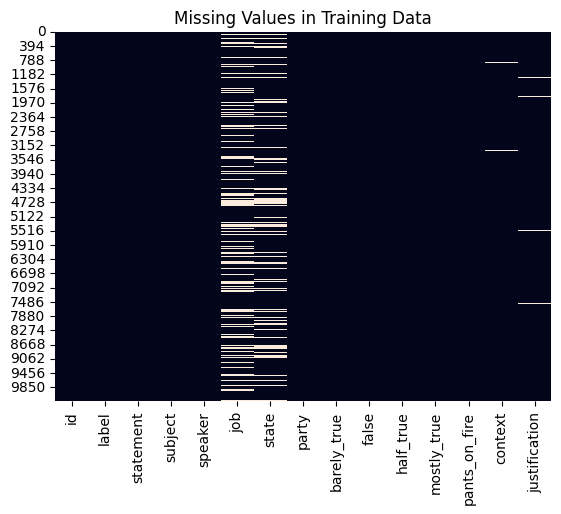

In [14]:
# Missing values visualization
sns.heatmap(df_train.isna(), cbar=False)
plt.title("Missing Values in Training Data")
plt.show()

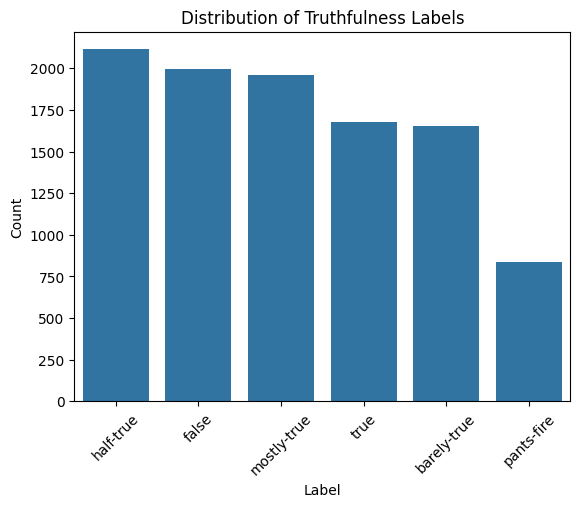

In [15]:
# Counts of Truthfulness Labels
sns.countplot(data=df_train, x="label", order=df_train["label"].value_counts().index)
plt.title("Distribution of Truthfulness Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Echo Chamber

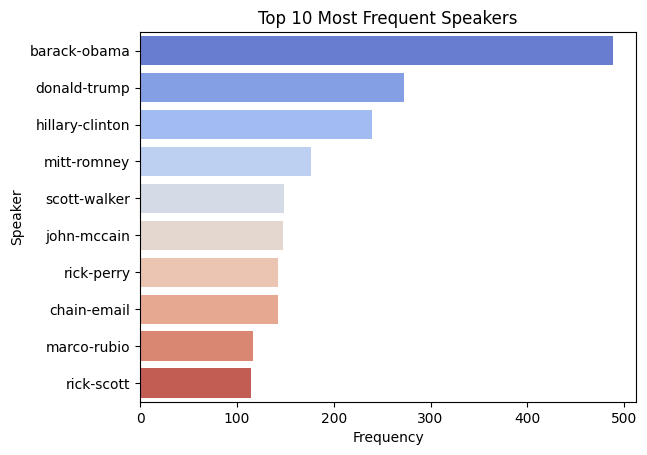

In [17]:
# Calculating and visualizing Top 10 Frequent Speakers
top_speakers = df_train["speaker"].value_counts().nlargest(10)

sns.barplot(
    x=top_speakers.values,
    y=top_speakers.index,
    hue=top_speakers.index,
    palette="coolwarm",
    legend=False
)

plt.title("Top 10 Most Frequent Speakers")
plt.xlabel("Frequency")
plt.ylabel("Speaker")
plt.show()

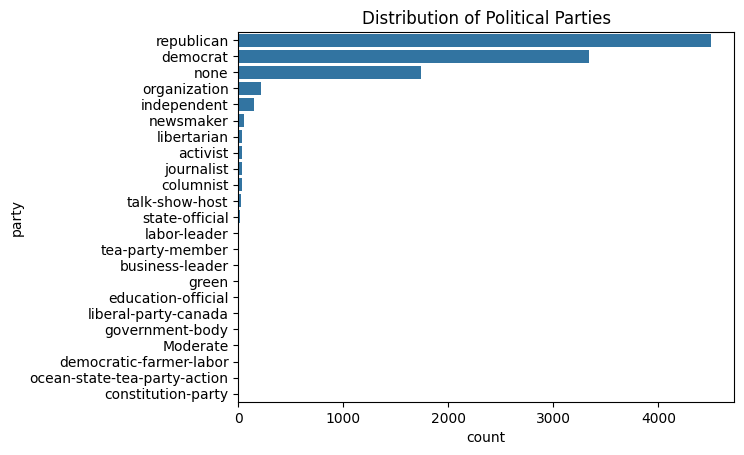

In [18]:
# Political Party distribution
sns.countplot(data=df_train, y="party", order=df_train["party"].value_counts().index)
plt.title("Distribution of Political Parties")
plt.show()

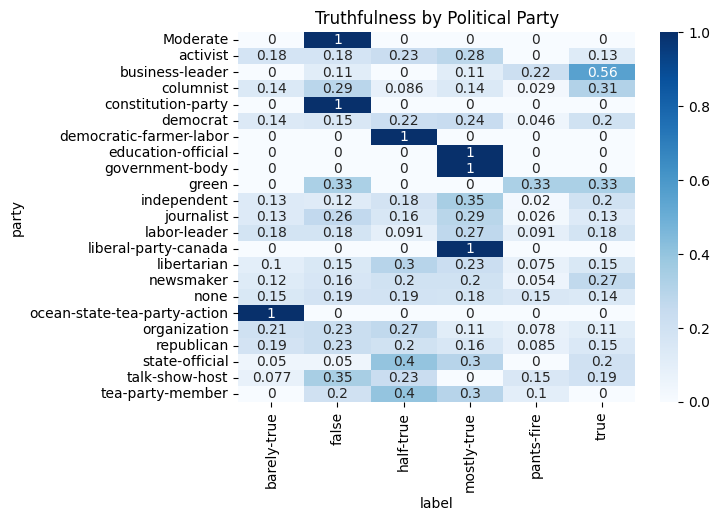

In [19]:
# Visualization of truthfulness by political party
sns.heatmap(pd.crosstab(df_train["party"], df_train["label"], normalize="index"), annot=True, cmap="Blues")
plt.title("Truthfulness by Political Party")
plt.show()

## Frequency Heuristic

In [20]:
subject_counts = Counter(chain.from_iterable(df_train['subject'].dropna().str.split(',')))
subject_df = pd.DataFrame(subject_counts.most_common(15), columns=['Subject', 'Count'])

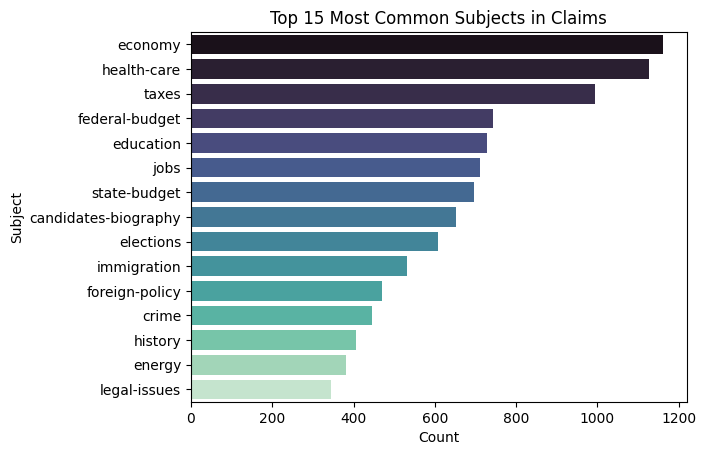

In [22]:
# Most common subjects in claims
sns.barplot(
    data=subject_df,
    x='Count',
    y='Subject',
    hue='Subject',
    palette='mako',
    legend=False
)

plt.title("Top 15 Most Common Subjects in Claims")
plt.show()

## Sensationalism

In [23]:
df_train['statement_length'] = df_train['statement'].apply(lambda x: len(str(x).split()))

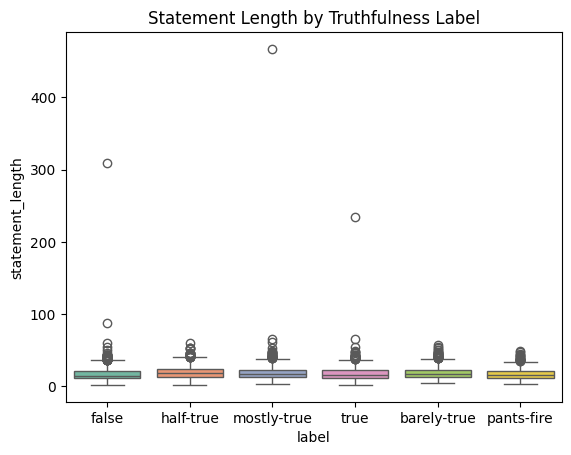

In [24]:
# Length by truth level visual
sns.boxplot(
    data=df_train,
    x='label',
    y='statement_length',
    hue='label',
    palette='Set2',
    legend=False
)

plt.title("Statement Length by Truthfulness Label")
plt.show()

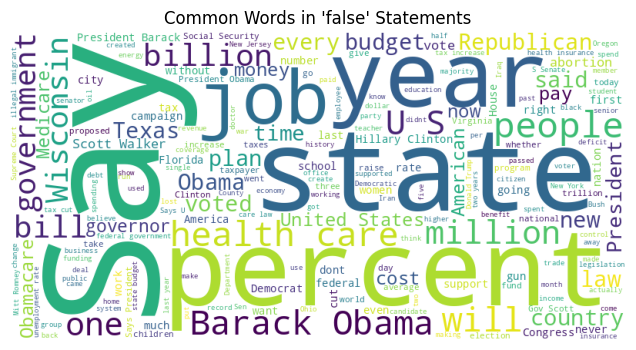

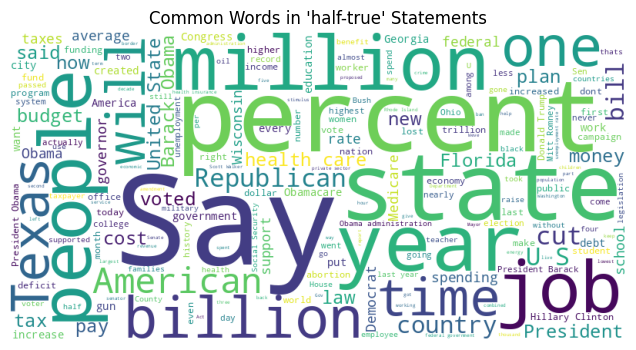

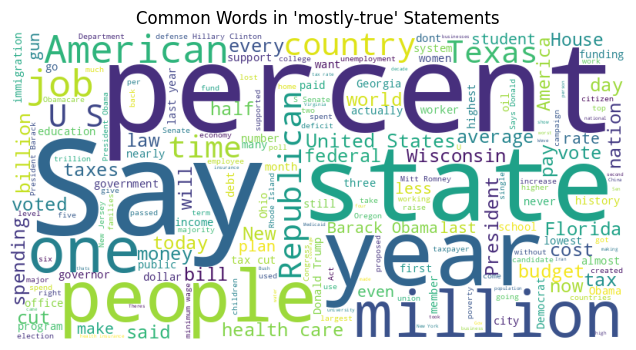

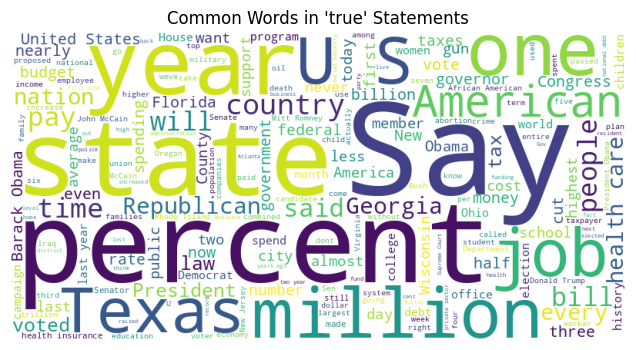

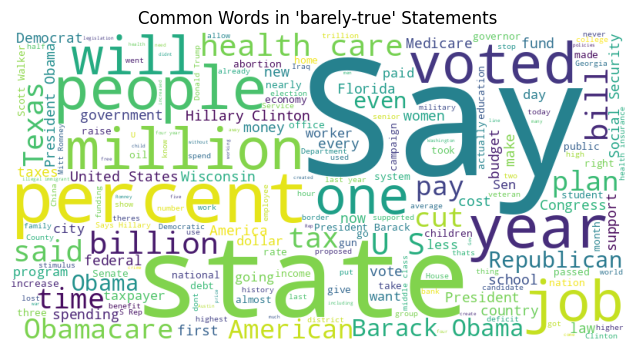

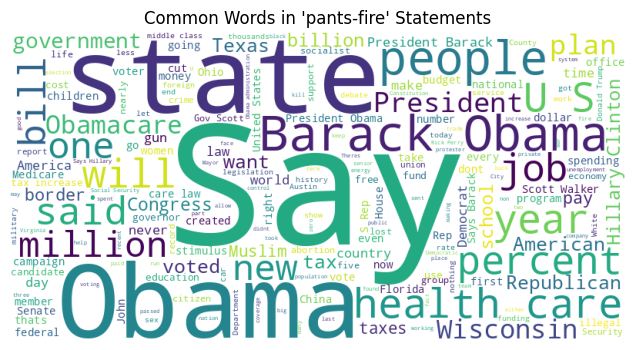

In [25]:
for label in df_train['label'].unique():
    text = " ".join(df_train[df_train['label']==label]['statement'].astype(str))
    plt.figure(figsize=(8,4))
    plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(text))
    plt.axis('off')
    plt.title(f"Common Words in '{label}' Statements")
    plt.show()

## Credibility

In [26]:
speaker_scores = df_train.groupby("speaker")[["barely_true", "false", "half_true", "mostly_true", "pants_on_fire"]].sum()
speaker_scores["credibility_score"] = (
    (speaker_scores["mostly_true"] + speaker_scores["half_true"]) -
    (speaker_scores["false"] + speaker_scores["pants_on_fire"])
)

In [27]:
top_cred = speaker_scores["credibility_score"].nlargest(10)
low_cred = speaker_scores["credibility_score"].nsmallest(10)

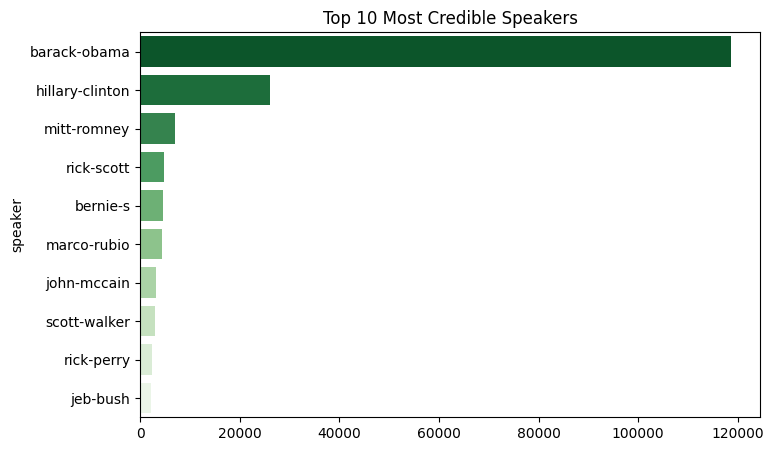

In [28]:
# Most credible speakers visual
plt.figure(figsize=(8,5))
sns.barplot(
    x=top_cred.values,
    y=top_cred.index,
    hue=top_cred.index,
    palette="Greens_r",
    legend=False
)
plt.title("Top 10 Most Credible Speakers")
plt.show()

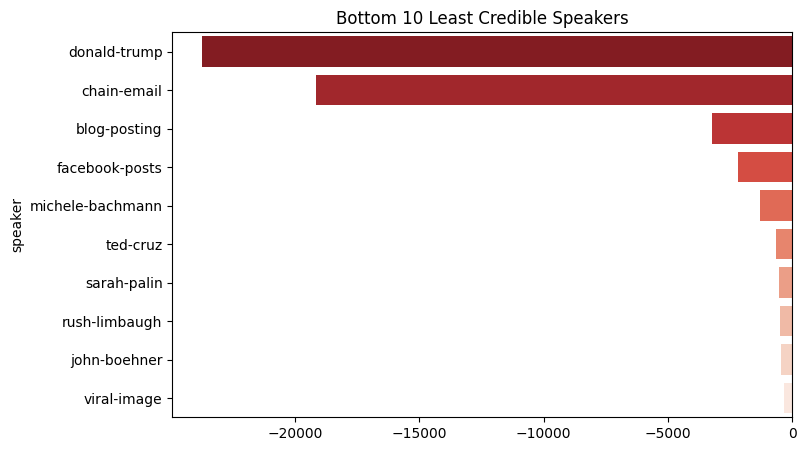

In [29]:
# Least credible speakers
plt.figure(figsize=(8,5))
sns.barplot(
    x=low_cred.values,
    y=low_cred.index,
    hue=low_cred.index,
    palette="Reds_r",
    legend=False
)
plt.title("Bottom 10 Least Credible Speakers")
plt.show()

## Cross-Factor Validation

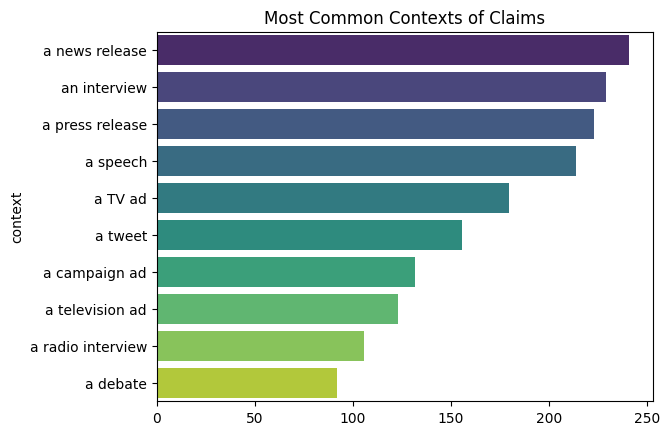

In [31]:
# Most common context found within claims
context_counts = df_train["context"].value_counts().nlargest(10)

sns.barplot(
    x=context_counts.values,
    y=context_counts.index,
    hue=context_counts.index,
    palette="viridis",
    legend=False
)

plt.title("Most Common Contexts of Claims")
plt.show()

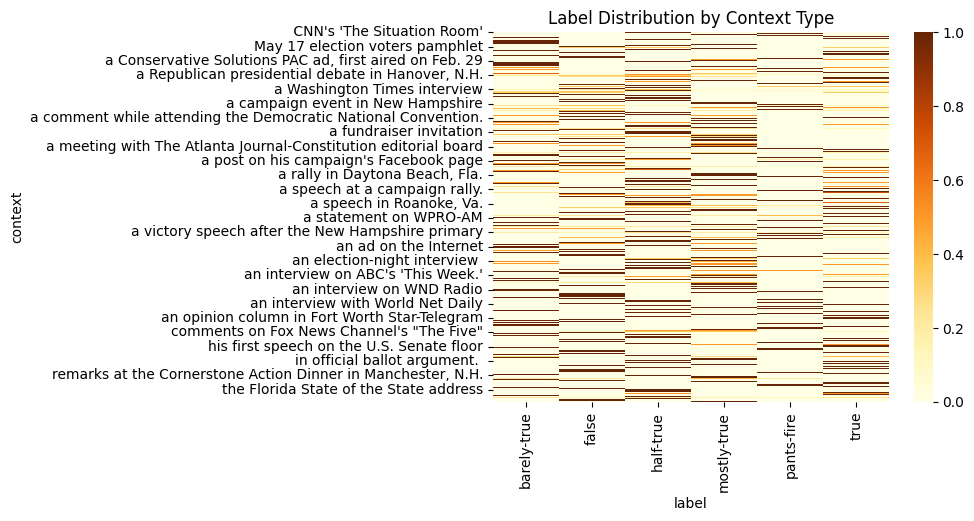

In [32]:
sns.heatmap(pd.crosstab(df_train["context"], df_train["label"], normalize="index"), cmap="YlOrBr")
plt.title("Label Distribution by Context Type")
plt.show()